# Homework 4: Predictive Process Monitoring

* This task uses the [Turnaround process event log](http://kodu.ut.ee/~chavez85/pm_course/data/turnaround_anon_sla.csv)  that we used in Practice 9 of the course. The link has been provided in Slack. 

* This goal of this homework is to train and use predictive process monitoring techniques to predict the outcome of a process from a log of events. Make the necessary modifications to the framework proposed by Taineema et al. (link 1 ) reviewed in class to meet this goal.

In [1]:
# python optimize_params.py turnaround_anon_sla param_dir_mahmoud 1  cluster index xgboost 
# python experiments.py turnaround_anon_sla param_dir_mahmoud results_dir_mahmoud cluster index xgboost 1 10 4


In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from pandas_profiling import ProfileReport

In [3]:
file_path = 'http://kodu.ut.ee/~chavez85/pm_course/data/turnaround_anon_sla.csv'
df = pd.read_csv(file_path)
df.head()

,caseid,activity,start_timestamp,end_timestamp,SLA MIN
0,Case00,A0,2017-07-12 11:47:00,2017-07-12 11:48:00,35.0
1,Case00,A1,2017-07-12 11:57:00,2017-07-12 11:57:00,35.0
2,Case00,A2,2017-07-12 12:34:00,2017-07-12 12:34:00,35.0
3,Case00,A3,2017-07-12 11:57:00,2017-07-12 11:59:00,35.0
4,Case00,A4,2017-07-12 11:43:00,2017-07-12 11:43:00,35.0


#### 1. (1 point) As part of the log preprocessing, it is necessary to categorize the process traces as deviant or regular. This log contains a column called SLA. it is a "case attribute," which indicates how many minutes each case must complete. You must create a new column in the log that contains a case attribute called label, which contains a value of 1 for deviant cases or 0 for regular ones. This column's value is 0 if the duration of the case (in minutes) is less than or equal to the SLA; otherwise, this column's value must be 1 (the SLA has not been met). NB! If there are cases that do not have SLA, categorize them as 0.

* **1.1 Data Preprocessing.**

In [4]:
df['start_timestamp'] = pd.to_datetime(df['start_timestamp'], format='%Y-%m-%d %H:%M')
df['end_timestamp'] = pd.to_datetime(df['end_timestamp'], format='%Y-%m-%d %H:%M')


def irregular_cases(data):
    cases = list()
    for key, group in data.groupby('caseid'):
        if len(group['SLA MIN'].unique())>1:
            cases.append(key)
    print(cases)
            
irregular_cases(df)

df[df.caseid=='Case18']['SLA MIN'].unique()

df.loc[df.caseid=='Case18', 'SLA MIN'] = 35.0
irregular_cases(df)

sla = df[['caseid', 'SLA MIN']].drop_duplicates()
sla = {x['caseid']: x['SLA MIN'] for x in sla.to_dict('records')}
sla.items()
#df.dtypes

['Case18']
[]


dict_items([('Case00', 35.0), ('Case01', 60.0), ('Case02', 35.0), ('Case03', 45.0), ('Case04', 50.0), ('Case05', nan), ('Case06', 45.0), ('Case07', 45.0), ('Case08', nan), ('Case09', 45.0), ('Case10', nan), ('Case11', 45.0), ('Case12', 35.0), ('Case13', 50.0), ('Case14', 50.0), ('Case15', nan), ('Case16', 35.0), ('Case17', 30.0), ('Case18', 35.0), ('Case19', 35.0), ('Case20', 35.0), ('Case21', 45.0), ('Case22', nan), ('Case23', 35.0), ('Case24', 40.0), ('Case25', 45.0), ('Case26', nan), ('Case27', nan), ('Case28', nan), ('Case29', nan), ('Case30', 35.0), ('Case31', nan), ('Case32', 35.0), ('Case33', 45.0), ('Case34', 35.0), ('Case35', 45.0), ('Case36', 35.0), ('Case37', 45.0), ('Case38', nan), ('Case39', 35.0), ('Case40', 45.0), ('Case41', nan), ('Case42', 35.0), ('Case43', 45.0), ('Case44', 45.0), ('Case45', 45.0), ('Case46', 45.0), ('Case47', 45.0), ('Case48', 60.0), ('Case49', 35.0), ('Case50', 60.0), ('Case51', 45.0), ('Case52', 35.0), ('Case53', 45.0), ('Case54', nan), ('Case55', 

In [5]:
# from pandas_profiling import ProfileReport
# profile = ProfileReport(df, title='Pandas Profiling Report')
# profile

In [6]:
# def irregular_cases(data):
#   cases = list()
#   for key, group in data.groupby('caseid'):
#     if len(group['SLA MIN'].unique())>1:
#       cases.append(key)
#   print(cases)
# irregular_cases(df)

In [7]:
#df[df.caseid=='Case18']['SLA MIN'].unique()

In [8]:
#df.loc[df.caseid=='Case18', 'SLA MIN'] = 35.0
#irregular_cases(df)

In [9]:
sla = df[['caseid', 'SLA MIN']].drop_duplicates()
sla = {x['caseid']: x['SLA MIN'] for x in sla.to_dict('records')}
sla.items()

dict_items([('Case00', 35.0), ('Case01', 60.0), ('Case02', 35.0), ('Case03', 45.0), ('Case04', 50.0), ('Case05', nan), ('Case06', 45.0), ('Case07', 45.0), ('Case08', nan), ('Case09', 45.0), ('Case10', nan), ('Case11', 45.0), ('Case12', 35.0), ('Case13', 50.0), ('Case14', 50.0), ('Case15', nan), ('Case16', 35.0), ('Case17', 30.0), ('Case18', 35.0), ('Case19', 35.0), ('Case20', 35.0), ('Case21', 45.0), ('Case22', nan), ('Case23', 35.0), ('Case24', 40.0), ('Case25', 45.0), ('Case26', nan), ('Case27', nan), ('Case28', nan), ('Case29', nan), ('Case30', 35.0), ('Case31', nan), ('Case32', 35.0), ('Case33', 45.0), ('Case34', 35.0), ('Case35', 45.0), ('Case36', 35.0), ('Case37', 45.0), ('Case38', nan), ('Case39', 35.0), ('Case40', 45.0), ('Case41', nan), ('Case42', 35.0), ('Case43', 45.0), ('Case44', 45.0), ('Case45', 45.0), ('Case46', 45.0), ('Case47', 45.0), ('Case48', 60.0), ('Case49', 35.0), ('Case50', 60.0), ('Case51', 45.0), ('Case52', 35.0), ('Case53', 45.0), ('Case54', nan), ('Case55', 

* **1.2 Calculate duration for cases in minuites.**

In [10]:
df_casedur = list()
for id, group in df.groupby('caseid'):
  df_casedur.append({'caseid': id, 'dur_min': (group['end_timestamp'].max() - group['start_timestamp'].min()).total_seconds()/60})
df_casedur = pd.DataFrame(df_casedur)
df_casedur

,caseid,dur_min
0,Case00,56.0
1,Case01,73.0
2,Case02,47.0
3,Case03,49.0
4,Case04,63.0
...,...,...
62,Case62,50.0
63,Case63,83.0
64,Case64,80.0
65,Case65,95.0


* **1.3 Add label column.**

In [11]:
import math
def sla_label(x):
  if math.isnan(sla[x.caseid]) or  x.dur_min <= sla[x.caseid]:
    return "regular"#0
  else:
    return "deviant"#1
df_casedur['label'] = df_casedur.apply(sla_label, axis=1)
df_casedur

,caseid,dur_min,label
0,Case00,56.0,deviant
1,Case01,73.0,deviant
2,Case02,47.0,deviant
3,Case03,49.0,deviant
4,Case04,63.0,deviant
...,...,...,...
62,Case62,50.0,deviant
63,Case63,83.0,regular
64,Case64,80.0,deviant
65,Case65,95.0,deviant


In [12]:
df = df.merge(df_casedur, how='left', on='caseid')
df.head()

,caseid,activity,start_timestamp,end_timestamp,SLA MIN,dur_min,label
0,Case00,A0,2017-07-12 11:47:00,2017-07-12 11:48:00,35.0,56.0,deviant
1,Case00,A1,2017-07-12 11:57:00,2017-07-12 11:57:00,35.0,56.0,deviant
2,Case00,A2,2017-07-12 12:34:00,2017-07-12 12:34:00,35.0,56.0,deviant
3,Case00,A3,2017-07-12 11:57:00,2017-07-12 11:59:00,35.0,56.0,deviant
4,Case00,A4,2017-07-12 11:43:00,2017-07-12 11:43:00,35.0,56.0,deviant


#### 2. (2 points) Add a column to the event log that captures the WIP of the process at the moment where the last event in the prefix occurs. Remember that the WIP refers to the number of active cases, meaning the number of cases that have started but not yet completed.

In [13]:
# function to compute WIP
def get_wip(date):
    return sum((dt_first_last_timestamps["start_time"] <= date) & (dt_first_last_timestamps["end_time"] > date))


In [14]:
# add inter-case features
data = df
data = data.sort_values(["start_timestamp"], ascending=True, kind='mergesort')
dt_first_last_timestamps = data.groupby("caseid")["start_timestamp"].agg([min, max])
dt_first_last_timestamps.columns = ["start_time", "end_time"]
data["wip"] = data["start_timestamp"].apply(get_wip)
data.reset_index(drop=True, inplace=True)
data

,caseid,activity,start_timestamp,end_timestamp,SLA MIN,dur_min,label,wip
0,Case33,A14,2017-07-04 11:13:00,2017-07-04 11:13:00,45.0,60.0,deviant,1
1,Case33,A6,2017-07-04 11:16:00,2017-07-04 11:16:00,45.0,60.0,deviant,1
2,Case33,A0,2017-07-04 11:19:00,2017-07-04 11:21:00,45.0,60.0,deviant,1
3,Case33,A3,2017-07-04 11:19:00,2017-07-04 11:28:00,45.0,60.0,deviant,1
4,Case33,A4,2017-07-04 11:21:00,2017-07-04 11:21:00,45.0,60.0,deviant,1
...,...,...,...,...,...,...,...,...
2441,Case66,A5,2017-08-10 15:40:00,2017-08-10 15:40:00,45.0,51.0,deviant,1
2442,Case66,A43,2017-08-10 15:40:00,2017-08-10 15:40:00,45.0,51.0,deviant,1
2443,Case66,A49,2017-08-10 15:42:00,2017-08-10 15:42:00,45.0,51.0,deviant,1
2444,Case66,A2,2017-08-10 15:51:00,2017-08-10 15:51:00,45.0,51.0,deviant,0


#### (4 points) Currently, the work proposed by Taineema et al. performs the extraction of the prefixes of the traces registered in the log to train the classification models. For large logs, this approach leads to an increase in the dimensionality of the models' input (too many features) without necessarily improving its precision, especially in cases in which the event traces are very long. You must modify this technique to extract subsequences of size n ( n-grams), where n is a user- defined parameter, instead of encoding entire prefixes. An n-gram is a contiguous sequence of nitems from a given trace. For example, in the following trace of a process, all possible n-grams of size three were extracted:

In [15]:
data.rename(columns = {'caseid' : 'Case ID', 'activity' : 'Activity', "start_timestamp":"time:timestamp"}, inplace = True)
del data['end_timestamp']
data.to_csv('./../experiments/logs/turnaround_anon_sla.csv', sep=';', index=False)

In [16]:
## 
tmp =data
log=data
timestamp_col = 'time:timestamp'
def add_ngram(group, ngr):    
    group = group.sort_values(timestamp_col, ascending=True, kind='mergesort').reset_index(drop=True)    
    results=pd.DataFrame()
    ngram_value = ngr
    for index, row in group.iterrows():
        df = pd.DataFrame(group.iloc[index:index+ngram_value,:], columns=tmp.columns)
        df['orig_case_id'] = df['Case ID']+"_"+str(index+1)
        df['subsequence_nr'] = index+1
        results = pd.concat([results, df], axis=0)    
    return results

# GAP parameter
def generate_prefix_data_ngram(data, ngram_s):  # min_length, max_length, gap=1):
    ngr = ngram_s
    dt_prefixes = data.groupby('Case ID').apply(add_ngram, ngr)
    dt_prefixes.reset_index(drop=True, inplace=True)
    dt_prefixes = dt_prefixes.rename(columns={'Case ID':'orig_case_id', 'orig_case_id':'Case ID' })

    return dt_prefixes

ngram_s = 4
dt_prefixes = generate_prefix_data_ngram(tmp, ngram_s)
dt_prefixes.head(20)

,orig_case_id,Activity,time:timestamp,SLA MIN,dur_min,label,wip,Case ID,subsequence_nr
0,Case00,A4,2017-07-12 11:43:00,35.0,56.0,deviant,1,Case00_1,1
1,Case00,A0,2017-07-12 11:47:00,35.0,56.0,deviant,1,Case00_1,1
2,Case00,A8,2017-07-12 11:49:00,35.0,56.0,deviant,1,Case00_1,1
3,Case00,A1,2017-07-12 11:57:00,35.0,56.0,deviant,1,Case00_1,1
4,Case00,A0,2017-07-12 11:47:00,35.0,56.0,deviant,1,Case00_2,2
5,Case00,A8,2017-07-12 11:49:00,35.0,56.0,deviant,1,Case00_2,2
6,Case00,A1,2017-07-12 11:57:00,35.0,56.0,deviant,1,Case00_2,2
7,Case00,A3,2017-07-12 11:57:00,35.0,56.0,deviant,1,Case00_2,2
8,Case00,A8,2017-07-12 11:49:00,35.0,56.0,deviant,1,Case00_3,3
9,Case00,A1,2017-07-12 11:57:00,35.0,56.0,deviant,1,Case00_3,3


#### (3 points) Test the results of your modifications with the Turnaround process event log using cluster bucketing, index encoding, and the XGboost model.

In [17]:
train_ratio = 0.8
n_splits = 2
random_state = 22

In [18]:
# determine min and max (truncated) prefix lengths
min_prefix_length = 1
def get_pos_case_length_quantile(data, quantile=0.90):
    return int(np.ceil(data.groupby('Case ID').size().quantile(quantile)))
max_prefix_length = min(40, get_pos_case_length_quantile(log, 0.90))

In [19]:
# split into training and test
def split_data_strict(data, train_ratio, split="temporal"):  
    # split into train and test using temporal split and discard events that overlap the periods
    data = data.sort_values(['time:timestamp', 'Activity'], ascending=True, kind='mergesort')
    grouped = data.groupby('Case ID')
    start_timestamps = grouped['time:timestamp'].min().reset_index()
    start_timestamps = start_timestamps.sort_values('time:timestamp', ascending=True, kind='mergesort')
    train_ids = list(start_timestamps['Case ID'])[:int(train_ratio*len(start_timestamps))]
    train = data[data['Case ID'].isin(train_ids)].sort_values(['time:timestamp', 'Activity'], ascending=True, kind='mergesort')
    test = data[~data['Case ID'].isin(train_ids)].sort_values(['time:timestamp', 'Activity'], ascending=True, kind='mergesort')
    split_ts = test['time:timestamp'].min()
    train = train[train['time:timestamp'] < split_ts]
    return (train, test)

In [20]:
train, test = split_data_strict(log, train_ratio, split="temporal")
print(len(train))
train.head()

1909


,Case ID,Activity,time:timestamp,SLA MIN,dur_min,label,wip
0,Case33,A14,2017-07-04 11:13:00,45.0,60.0,deviant,1
1,Case33,A6,2017-07-04 11:16:00,45.0,60.0,deviant,1
2,Case33,A0,2017-07-04 11:19:00,45.0,60.0,deviant,1
3,Case33,A3,2017-07-04 11:19:00,45.0,60.0,deviant,1
4,Case33,A4,2017-07-04 11:21:00,45.0,60.0,deviant,1


In [21]:
print(len(test))
test.head()

496


,Case ID,Activity,time:timestamp,SLA MIN,dur_min,label,wip
1909,Case54,A0,2017-08-03 13:19:00,NaN,73.0,regular,2
1910,Case54,A1,2017-08-03 13:21:00,NaN,73.0,regular,2
1911,Case54,A35,2017-08-03 13:23:00,NaN,73.0,regular,2
1912,Case54,A23,2017-08-03 13:24:00,NaN,73.0,regular,2
1913,Case54,A14,2017-08-03 13:25:00,NaN,73.0,regular,2


In [22]:
from sklearn.model_selection import StratifiedKFold
def get_stratified_split_generator(data, n_splits=5, shuffle=True, random_state=22):
    grouped_firsts = data.groupby('Case ID', as_index=False).first()
    skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    for train_index, test_index in skf.split(grouped_firsts, grouped_firsts['label']):
        current_train_names = grouped_firsts['Case ID'][train_index]
        train_chunk = data[data['Case ID'].isin(current_train_names)].sort_values('time:timestamp', ascending=True, kind='mergesort')
        test_chunk = data[~data['Case ID'].isin(current_train_names)].sort_values('time:timestamp', ascending=True, kind='mergesort')
        yield (train_chunk, test_chunk)

def get_class_ratio(data):
    class_freqs = data['label'].value_counts()
    print(class_freqs)
    return class_freqs[1] / class_freqs.sum()



In [23]:
# prepare chunks for CV
dt_prefixes = []
class_ratios = []
for train_chunk, test_chunk in get_stratified_split_generator(train, n_splits=n_splits):
    #test_chunk = test_chunk.rename(columns={"Case ID":"caseid"})
    #train_chunk = train_chunk.rename(columns={"Case ID":"caseid"})
    class_ratios.append(get_class_ratio(train_chunk))
    # generate data where each prefix is a separate instance
    #dt_prefixes.append(generate_prefix_data(test_chunk, min_prefix_length, max_prefix_length))
    dt_prefixes.append(generate_prefix_data_ngram(test_chunk, 4))
del train

deviant    673
regular    239
Name: label, dtype: int64
deviant    779
regular    218
Name: label, dtype: int64


In [24]:
import BucketFactory

In [25]:
# encoding_method = "last", "agg", "index"
# Bucketing prefixes based on control flow
bucketer_args = {'encoding_method': 'index', 
                 'case_id_col': 'Case ID', 
                 'cat_cols':['Activity'], 
                 'num_cols':['SLA MIN', 'dur_min', 'wip'], 
                 'random_state':random_state}


In [26]:
cv_iter = 0
dt_test_prefixes = dt_prefixes[cv_iter]
dt_train_prefixes = pd.DataFrame()
for cv_train_iter in range(n_splits): 
    if cv_train_iter != cv_iter:
        dt_train_prefixes = pd.concat([dt_train_prefixes, dt_prefixes[cv_train_iter]], axis=0)

#bucket_methods = "single", "prefix", "state", "cluster", "knn"
bucket_method = 'cluster'
if bucket_method == "cluster":
    bucketer_args["n_clusters"] = 3
bucketer = BucketFactory.get_bucketer(bucket_method, **bucketer_args)
bucket_assignments_train = bucketer.fit_predict(dt_train_prefixes)
bucket_assignments_test = bucketer.predict(dt_test_prefixes)

In [27]:
dt_test_prefixes

,orig_case_id,Activity,time:timestamp,SLA MIN,dur_min,label,wip,Case ID,subsequence_nr
0,Case05,A0,2017-07-17 07:29:00,NaN,73.0,regular,1,Case05_1,1
1,Case05,A1,2017-07-17 07:33:00,NaN,73.0,regular,1,Case05_1,1
2,Case05,A3,2017-07-17 07:34:00,NaN,73.0,regular,1,Case05_1,1
3,Case05,A4,2017-07-17 07:34:00,NaN,73.0,regular,1,Case05_1,1
4,Case05,A1,2017-07-17 07:33:00,NaN,73.0,regular,1,Case05_2,2
...,...,...,...,...,...,...,...,...,...
3821,Case53,A2,2017-08-03 12:40:00,45.0,53.0,deviant,2,Case53_30,30
3822,Case53,A32,2017-08-03 12:40:00,45.0,53.0,deviant,2,Case53_30,30
3823,Case53,A2,2017-08-03 12:40:00,45.0,53.0,deviant,2,Case53_31,31
3824,Case53,A32,2017-08-03 12:40:00,45.0,53.0,deviant,2,Case53_31,31


In [28]:
print('Train assignments:')
bucket_assignments_train
print(pd.DataFrame(bucket_assignments_train, columns=['bucket']).bucket.value_counts())
print('Test assignments:')
bucket_assignments_test
print(pd.DataFrame(bucket_assignments_test, columns=['bucket']).bucket.value_counts())

Train assignments:
1    624
2    227
0     61
Name: bucket, dtype: int64
Test assignments:
1    755
2    176
0     66
Name: bucket, dtype: int64


In [29]:
dt_train_prefixes

,orig_case_id,Activity,time:timestamp,SLA MIN,dur_min,label,wip,Case ID,subsequence_nr
0,Case00,A4,2017-07-12 11:43:00,35.0,56.0,deviant,1,Case00_1,1
1,Case00,A0,2017-07-12 11:47:00,35.0,56.0,deviant,1,Case00_1,1
2,Case00,A8,2017-07-12 11:49:00,35.0,56.0,deviant,1,Case00_1,1
3,Case00,A1,2017-07-12 11:57:00,35.0,56.0,deviant,1,Case00_1,1
4,Case00,A0,2017-07-12 11:47:00,35.0,56.0,deviant,1,Case00_2,2
...,...,...,...,...,...,...,...,...,...
3490,Case51,A2,2017-08-02 13:26:00,45.0,59.0,deviant,0,Case51_30,30
3491,Case51,A32,2017-08-02 13:26:00,45.0,59.0,deviant,0,Case51_30,30
3492,Case51,A2,2017-08-02 13:26:00,45.0,59.0,deviant,0,Case51_31,31
3493,Case51,A32,2017-08-02 13:26:00,45.0,59.0,deviant,0,Case51_31,31


In [30]:
bucket_number = 2

bucket_indexes = dt_train_prefixes.groupby('Case ID').first().index
bucket_indexes = bucket_indexes[bucket_assignments_train == bucket_number]
print(bucket_indexes)
bucket_data = dt_train_prefixes[dt_train_prefixes['Case ID'].isin(bucket_indexes)]
bucket_data
def get_label_numeric(data):
    y = data.groupby('Case ID').first()['label'] # one row per case
    return [label for label in y]
train_y = get_label_numeric(bucket_data)

Index(['Case08_1', 'Case08_10', 'Case08_11', 'Case08_12', 'Case08_13',
       'Case08_14', 'Case08_15', 'Case08_16', 'Case08_17', 'Case08_18',
       ...
       'Case41_36', 'Case41_37', 'Case41_38', 'Case41_39', 'Case41_4',
       'Case41_5', 'Case41_6', 'Case41_7', 'Case41_8', 'Case41_9'],
      dtype='object', name='Case ID', length=227)


In [31]:
len(train_y)

227

In [32]:
bucket_indexes = dt_test_prefixes.groupby('Case ID').first().index
bucket_indexes = bucket_indexes[bucket_assignments_test == bucket_number]
bucket_data_test = dt_test_prefixes[dt_test_prefixes['Case ID'].isin(bucket_indexes)]
bucket_data_test
test_y = get_label_numeric(bucket_data_test)

In [33]:
len(test_y)

176

In [34]:
import EncoderFactory
from sklearn.pipeline import FeatureUnion, Pipeline

In [35]:
log

,Case ID,Activity,time:timestamp,SLA MIN,dur_min,label,wip
0,Case33,A14,2017-07-04 11:13:00,45.0,60.0,deviant,1
1,Case33,A6,2017-07-04 11:16:00,45.0,60.0,deviant,1
2,Case33,A0,2017-07-04 11:19:00,45.0,60.0,deviant,1
3,Case33,A3,2017-07-04 11:19:00,45.0,60.0,deviant,1
4,Case33,A4,2017-07-04 11:21:00,45.0,60.0,deviant,1
...,...,...,...,...,...,...,...
2441,Case66,A5,2017-08-10 15:40:00,45.0,51.0,deviant,1
2442,Case66,A43,2017-08-10 15:40:00,45.0,51.0,deviant,1
2443,Case66,A49,2017-08-10 15:42:00,45.0,51.0,deviant,1
2444,Case66,A2,2017-08-10 15:51:00,45.0,51.0,deviant,0


In [36]:
cls_encoder_args = {'case_id_col': 'Case ID', 
                    'static_cat_cols':[],# ['Diagnose', 'DiagnosticArtAstrup', 'DiagnosticBlood', 'DiagnosticECG',
                     #  'DiagnosticIC', 'DiagnosticLacticAcid', 'DiagnosticLiquor',
                      # 'DiagnosticOther', 'DiagnosticSputum', 'DiagnosticUrinaryCulture',
                      # 'DiagnosticUrinarySediment', 'DiagnosticXthorax', 'DisfuncOrg',
                      # 'Hypotensie', 'Hypoxie', 'InfectionSuspected', 'Infusion', 'Oligurie',
                      # 'SIRSCritHeartRate', 'SIRSCritLeucos', 'SIRSCritTachypnea',
                      # 'SIRSCritTemperature', 'SIRSCriteria2OrMore'],
                    'static_num_cols': ['SLA MIN', 'dur_min'],
                    'dynamic_cat_cols': ['Activity',],
                    'dynamic_num_cols': ["wip"], 
                    'fillna': True}

encoding_dict = {
    "laststate": ["static", "last"],
    "agg": ["static", "agg"],
    "index": ["static", "index"],
    "combined": ["static", "last", "agg"]
}

methods = encoding_dict['index']

In [37]:
feature_combiner = FeatureUnion([(method, EncoderFactory.get_encoder(method, **cls_encoder_args)) for method in methods])
feature_combiner

FeatureUnion(transformer_list=[('static',
                                <transformers.StaticTransformer.StaticTransformer object at 0x7f89465a2730>),
                               ('index',
                                <transformers.IndexBasedTransformer.IndexBasedTransformer object at 0x7f89465a27f0>)])

In [38]:
encoding = feature_combiner.fit_transform(bucket_data, train_y)
encoding.shape

(227, 198)

In [39]:
encoding

array([[ 0., 77.,  1., ...,  0.,  0.,  0.],
       [ 0., 77.,  1., ...,  0.,  0.,  0.],
       [ 0., 77.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 0., 73.,  1., ...,  0.,  0.,  0.],
       [ 0., 73.,  1., ...,  0.,  0.,  0.],
       [ 0., 73.,  1., ...,  0.,  0.,  0.]])

In [40]:
pd.DataFrame(encoding).to_csv('encoding_hw4.csv')

In [41]:
from xgboost import XGBClassifier
model = XGBClassifier(n_estimators=500,
                               max_features=0.5,
                               random_state=random_state)

In [42]:
pipeline = Pipeline([('encoder', feature_combiner), ('cls', model)])
pipeline.fit(bucket_data, train_y)

/home/mshoush/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:09:33] WARNING: ../src/learner.cc:541: 
Parameters: { max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:09:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('encoder',
                 FeatureUnion(transformer_list=[('static',
                                                 <transformers.StaticTransformer.StaticTransformer object at 0x7f89465a2730>),
                                                ('index',
                                                 <transformers.IndexBasedTransformer.IndexBasedTransformer object at 0x7f89465a27f0>)])),
                ('cls',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gam...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, max_features=0.5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()

In [43]:
# preds_pos_label_idx = np.where(model.classes_ == 1)[0][0]
# preds = pipeline.predict_proba(bucket_data_test)[:,preds_pos_label_idx]
# print(preds)

In [44]:
# from sklearn.metrics import roc_auc_score
# score = roc_auc_score(test_y, preds)
# score

### Results evaluation

In [45]:
parms = pd.read_csv(os.path.join('parms', 'performance_results_xgboost_turnaround_anon_sla_cluster_index.csv'), sep=';')
parms = parms[['nr_events', 'cls', 'score']].drop_duplicates()
parms = parms[parms.score!=0]
parms.head()

,nr_events,cls,score
0,1,xgboost,0.925
1,2,xgboost,0.925
2,3,xgboost,0.925
3,4,xgboost,0.925
4,5,xgboost,0.925


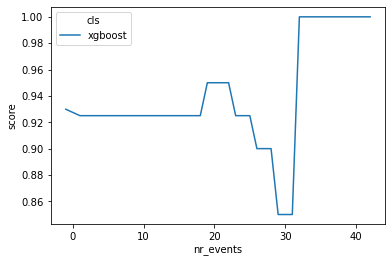

In [46]:
g = sns.lineplot(data=parms, x='nr_events', y='score', hue='cls')

In [47]:
print(parms[parms['nr_events']==-1]['score'])

43    0.929889
Name: score, dtype: float64


In [48]:
import numpy as np
print(f"Avg AUC: {np.round(list(parms[parms['nr_events']==-1]['score'])[0], 2)}")

Avg AUC: 0.93


<function matplotlib.pyplot.show(close=None, block=None)>

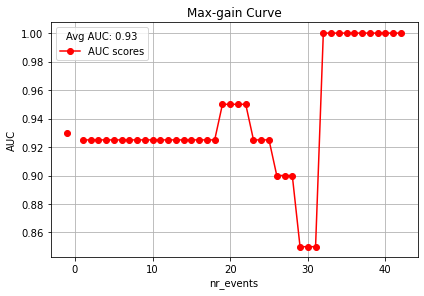

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(parms['nr_events'], parms['score'], label="AUC scores", marker="o", color='r')
plt.xlabel('nr_events')
plt.ylabel('AUC')
plt.legend(title="Avg AUC: %s"%np.round(list(parms[parms['nr_events']==-1]['score'])[0], 2), loc='best')
plt.grid(True)
plt.tight_layout()
plt.title('Max-gain Curve', )
plt.show

In [50]:
# from sklearn.ensemble import XG
# # max_features 0..1
# model = RandomForestClassifier(n_estimators=500,
#                                max_features=0.5,
#                                random_state=random_state)